# Measure Jet multiplicity

We measure the jet multiplicity.
$$ \rho_i = \frac{S_i - B_i}{\sum_{i}{S_i - B_i}} $$

We unfold to a "truth" level distribution using a reponse matrix.
The response matrix is defined as $\nu = $

In [1]:
import os, sys
sys.path.append(os.getcwd() + "/../")
from prep_ana_II import *
sys.path.append(os.getcwd() + "/../tools/")
sys.path.append(os.getcwd() + "/../tools/jecsys/")
from JECUncertainty import JECUncertainty, jecUncertainties
from lepton_eff import muonEff, electronEff
from cross_section_calc import calc_cross_stuff, cross_calc, stat_unc_calc, normalization_unc_calc

Welcome to JupyROOT 6.10/00
home /home/gunter/WW_analysis/production/Analysis_13TeV
Loading binning options...
Loading plotting options
unc_mc_process and scales are parameter dictionaries


In [2]:
%matplotlib inline

In [3]:
#Setup
matplotlib.rcParams.update({'font.size': 26})

scales, df = load_testset() 
df_da = load_presel_w_fDY_fTT_DATA()

#df = pre_cuts(df)
#df_da = pre_cuts(df_da)

rfs = load_randomForest()

fDY = rfs["clf_fDY"]
fTT = rfs["clf_fTT"]

features_fDY = rfs["features_fDY"]
features_fTT = rfs["features_fTT"]

def load_ww(file_path="../data/gen_jets/WW_WW_36.root", rfs=rfs):
    df_ww = rp.read_root(file_path)
    
    fDY = rfs["clf_fDY"]
    fTT = rfs["clf_fTT"]
    features_fDY = rfs["features_fDY"]
    features_fTT = rfs["features_fTT"]
    pred_fTT = fTT.predict_proba(np.float32(df_ww[features_fTT].values))
    df_ww["pred_fTT_WW"] = pred_fTT[:,0]
    pred_fDY = fDY.predict_proba(np.float32(df_ww[features_fDY].values))
    df_ww["pred_fDY_WW"] = pred_fDY[:,0]

    df_ww = pre_cuts(df_ww)

    return df_ww
df_ww = pre_cuts(load_ww())

##  Est. Measurements

In [4]:
def produce_jsf(df_ww, fdy, ftt):
    def jet_bin_conv(arr):
        l = np.zeros(3)
        for it in range(arr.shape[0]):
            if it < 2:
                l[it] += arr[it] 
            else:
                l[2] += arr[it]
        return l
    a = np.histogram(df_ww.numb_jets_24.values, 
                     weights=df_ww.weight.values,
                     range=(-0.5, 9.5), bins=10)
    b = np.histogram(df_ww.query("pred_fDY_WW > " + str(fdy) + " & pred_fTT_WW > " + str(ftt) ).numb_jets_24.values, 
                     weights=df_ww.query("pred_fDY_WW > " + str(fdy) + " & pred_fTT_WW > " + str(ftt)).weight.values,
                     range=(-0.5, 9.5), bins=10)

    sf = jet_bin_conv(a[0]) / jet_bin_conv(b[0])
    return sf
sf = produce_jsf(df_ww, 0.9, 0.2)
print "scale factors", sf

scale factors [ 1.67685166  1.86150668  2.87568617]


In [5]:
#Number of jets 
def table_jet_multi(df, scales=scales, fdy=0.9, ftt=0.2, printable=False):
    a = []
    for i in range(3):
        query = "pred_fDY_WW > " + str(fdy) + " & pred_fTT_WW > " + str(ftt) + " & numb_jets == " + str(i)
        if i == 2:
            query= "pred_fDY_WW > " + str(fdy) + " & pred_fTT_WW > " + str(ftt) + " &  numb_jets >= " + str(i)
            
        yields = process_yields(pre_cuts(df, False), pre_cuts(df_da, False), query=query, scales=scales)
        if printable == True: print "Jets: ", i, "\n", yields
        a.append(yields)
    return a
a = table_jet_multi(df)

In [6]:
#Construct measurements
def measure_jet_multi(tables):
    total = []
    bkg = []

    for i, ele in enumerate(tables):
        bkg.append(0)
        for process in ele.Process.unique():
            if process == "DATA":
                continue
            if "WW" in process:
                continue 
            if "Total" not in process:
                bkg[i] += ele[ele.Process == process]["Diff Flavor"].values[0] + ele[ele.Process == process]["Same Flavor"].values[0]
            else:
                total.append(ele[ele.Process == process]["Diff Flavor"].values[0] + ele[ele.Process == process]["Same Flavor"].values[0] )
    bkg = np.array(bkg, dtype=float)
    total = np.array(total, dtype=float)
    return total, bkg
total, bkg = measure_jet_multi(a)

In [7]:
print "Total", total
print "Background", bkg

Total [ 21212.  19145.   7874.]
Background [  8959.  13526.   5901.]


In [20]:
_temp_ASDFAEFAKGNAEWRGF = table_jet_multi(df, printable=True)

Jets:  0 
    Diff Flavor          Process  Same Flavor
0         10561               WW         1851
1           636  GluGluWWTo2L2Nu          192
2         11197        Total: WW         2043
3          1543               DY          404
4          3260              Top          885
5           255               WZ           73
6             3               ZZ           48
7           386            WG(*)           21
8           129            Higgs           27
9          1756               WJ          169
10        17629            Total         3583
11        20334             DATA         4109
Jets:  1 
    Diff Flavor          Process  Same Flavor
0          4936               WW          887
1           412  GluGluWWTo2L2Nu           98
2          5348        Total: WW          985
3           878               DY          854
4          7831              Top         1720
5           367               WZ           65
6             2               ZZ           19
7           28

### Fake data

In [8]:
# construct fake data
def construct_fake_data(total_table):
    np.random.seed(0)
    fake_data = []
    for i in range(3):
        fake_data.append( float(np.random.poisson(total_table[i],1)[0]) )
    fake_data = np.array(fake_data)
    return fake_data
fake_data = construct_fake_data(total)

In [9]:
fake_data - bkg

array([ 12273.,   5659.,   1954.])

### Measurement

In [11]:
# construct measurement
import pickle
matrices = pickle.load(open("../data/Unfolding/july2.pkl", "r"))
sf = matrices["sf"]


fake_measurement = []
for i in range(3):
    fake_measurement.append( sf[i] * float(fake_data[i] - bkg[i]) / ((sf*fake_data).sum() - (sf*bkg).sum())  )
fm = np.array(fake_measurement)
print fm

[ 0.56013143  0.28684071  0.15302786]


## Unfold Est. 

In [12]:
np.dot(np.linalg.inv(matrices["tot_matrix"]), fm)

array([ 0.57192884,  0.28015913,  0.14791209])

In [9]:
a = np.dot(np.linalg.inv(matrices["tot_matrix"]), fake_measurement - np.array([0.0222, 0.0237, 0.0209]))
b = np.dot(np.linalg.inv(matrices["tot_matrix"]), fake_measurement + np.array([0.0222, 0.0237, 0.0209]))
np.abs(a-b)/2.

array([ 0.02183075,  0.02361004,  0.02135922])

### nomalization unc

In [10]:
import copy
up = []
down = []
for process in scales:
    if process == "Data":
        continue
    if "WW" in process:
        continue
    if process not in df.process_decay.unique():
        continue
    alt_scales = copy.copy(scales)
    alt_scales[process] = scales[process] * (1. + unc_mc_process[process])
    a = table_jet_multi(df, scales=alt_scales)
    temp_, bkg = measure_jet_multi(a)
    fake_measurement = []
    for i in range(3):
        fake_measurement.append( sf[i] * float(fake_data[i] - bkg[i]) / ((sf*fake_data).sum() - (sf*bkg).sum())  )
    up.append(np.array(fake_measurement))
    
    alt_scales = copy.copy(scales)
    alt_scales[process] = scales[process] * (1. - unc_mc_process[process])
    a = table_jet_multi(df, scales=alt_scales)
    temp_, bkg = measure_jet_multi(a)
    fake_measurement = []
    for i in range(3):
        fake_measurement.append( sf[i] * float(fake_data[i] - bkg[i]) / ((sf*fake_data).sum() - (sf*bkg).sum())  )
    down.append(np.array(fake_measurement))
up = np.array(up)
down = np.array(down)

In [11]:
np.set_printoptions(suppress=True)
norm_unc =  ((np.abs( up - down ) / 2.)**2.).sum(0)**.5
temp_results = sf* (fake_data - bkg)/(sf*fake_data - sf*bkg).sum()

print "norm unc", norm_unc,\
"\nnorm unc (%)", norm_unc / temp_results * 100. 

norm unc [ 0.02438183  0.01056802  0.01386222] 
norm unc (%) [  4.10569444   3.92101368  10.14629642]


### Stat

In [12]:
def calc_stats(df):
    stats = 0.0
    for process in df.process_decay.unique():
        #if "WJ" in process: continue
        temp_df = pre_cuts(df, False)
        temp_df = temp_df[temp_df.process_decay == process]
        process_stats =( (temp_df.weight.values**2).sum()**.5/\
        temp_df.weight.values.sum() * scales[process] * temp_df.shape[0] )**2
        if temp_df.weight.values.sum() < 1.0:
            process_stats = 0
        if "WJ" in process: process_stats *= 2.0
        #print process, process_stats
        stats += process_stats
    return stats**.5


In [13]:
stat_unc = []
stats_b = calc_stats(df.query("pred_fDY_WW > 0.9 & pred_fTT_WW > 0.2"))
temp_results = []

print fake_data, bkg

for i in range(3):
    stats_a = calc_stats(df.query("pred_fDY_WW > 0.9 & pred_fTT_WW > 0.2 & numb_jets_24 == " + str(i)))
    if i == 2:
        stats_a = calc_stats(df.query("pred_fDY_WW > 0.9 & pred_fTT_WW > 0.2 & numb_jets_24 >= " + str(i)))
    a, sigma_a = sf[i] * (fake_data[i] - bkg[i]), (fake_data[i] + stats_a**2.)**.5 
    b, sigma_b = (sf*fake_data - sf*bkg).sum(), (fake_data.sum() + stats_b**2.)**.5
    
    #print a, b, a/b, sigma_a, sigma_b
    stat_unc.append( ( (sf[i] / b * sigma_a)**2. + ((sf[i] * a) / b**2. * sigma_b)**2. )**.5 )
    if i == 2:
        print "a", a, "b", b, "a/b", a/b
        print "sigma_a", sigma_a, "sigma_b", sigma_b
        print "term 1", sf[i] / b * sigma_a
        print "term 2", (sf[i] * a) / b**2. * sigma_b 
    temp_results.append(a/b)

#temp_results = ((fake_data - bkg)/(fake_data - bkg).sum())
temp_results = np.array(temp_results)
print "stat unc", np.array(stat_unc),\
"\nstat unc (%)", np.array(stat_unc) / temp_results * 100.

[ 22272.  20227.   8285.] [ 11084.  15655.   6785.]


/home/gunter/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


a 4317.0262659 b 31597.9945532 a/b 0.136623425852
sigma_a 142.999875065 sigma_b 458.908145389
term 1 0.0130247552185
term 2 0.00571064087404
stat unc [ 0.02101199  0.02146401  0.01422166] 
stat unc (%) [  3.53824206   7.96371445  10.40938758]


In [15]:
process_yields()

array([ 0.66461167,  0.24025808,  0.09513024])

In [16]:
sf

array([ 1.67720709,  1.86272428,  2.87801751])

# Test

## Stat

In [14]:
def calc_tot_stat_unc(df, fdy, ftt, scales=scales):
    np.random.seed(0)
    total, bkg = measure_jet_multi(table_jet_multi(df, scales=scales, fdy=fdy, ftt=ftt))
    print total, bkg, fdy, ftt
    fake_data = construct_fake_data(total)

    
    tot_total, tot_bkg = measure_jet_multi(table_jet_multi(df, scales=scales, fdy=-1, ftt=-1))
    
    sf = produce_jsf(df_ww, fdy, ftt)
    print tot_total, tot_bkg, sf
    
    temp_results = []
    stat_unc = []
    query = "pred_fDY_WW > "+ str(fdy) +" & pred_fTT_WW > " + str(ftt)
    stats_b = calc_stats(df.query(query))
    for i in range(3):
        stats_a = calc_stats(df.query(query + " & numb_jets_24 == " + str(i)))
        a, sigma_a = sf[i] * (fake_data[i] - bkg[i]), (fake_data[i] + stats_a**2.)**.5 
        b, sigma_b = (sf*fake_data - sf*bkg).sum(), (fake_data.sum() + stats_b**2.)**.5

        stat_unc.append( ( (sf[i] / b * sigma_a)**2. + ((sf[i] * a) / b**2. * sigma_b)**2. )**.5 )
        temp_results.append(a/b)

    temp_results = np.array(temp_results)
    #print "========= " + str(fdy) + " " + str(ftt) +"  ========="
    #print "stat unc", np.array(stat_unc),\
    #"\nstat unc (%)", np.array(stat_unc) / temp_results * 100.,\
    #"\n sf", sf
    return stat_unc, temp_results, sf

In [15]:
results = []
cuts = []
for i in range(0,21):
    ftt = 0.6 *  i / 20.0
    cuts.append(ftt)
    results.append( calc_tot_stat_unc(df, 0.9, ftt, scales=scales) )
results = np.array(results)
cuts = np.array(cuts)

[ 22424.  27104.  47434.] [ 11258.  22453.  46205.] 0.9 0.0
[ 1334659.   402214.   231758.] [ 1321892.   396596.   231015.] [ 1.66746998  1.66131644  1.61105854]
[ 22424.  26130.  33028.] [ 11258.  21477.  31463.] 0.9 0.03
[ 1334659.   402214.   231758.] [ 1321892.   396596.   231015.] [ 1.66762635  1.67008333  1.66687967]
[ 22424.  24614.  25079.] [ 11258.  19973.  23321.] 0.9 0.06
[ 1334659.   402214.   231758.] [ 1321892.   396596.   231015.] [ 1.66792994  1.68816083  1.76249068]
[ 22415.  23428.  19684.] [ 11249.  18786.  17866.] 0.9 0.09
[ 1334659.   402214.   231758.] [ 1321892.   396596.   231015.] [ 1.66869618  1.7133562   1.89884627]


/home/gunter/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


[ 22390.  22424.  15735.] [ 11225.  17801.  13920.] 0.9 0.12
[ 1334659.   402214.   231758.] [ 1321892.   396596.   231015.] [ 1.67019132  1.74189889  2.0760327 ]
[ 22354.  21536.  12573.] [ 11188.  16931.  10824.] 0.9 0.15
[ 1334659.   402214.   231758.] [ 1321892.   396596.   231015.] [ 1.67196869  1.77686833  2.31405937]
[ 22303.  20714.   9897.] [ 11138.  16149.   8264.] 0.9 0.18
[ 1334659.   402214.   231758.] [ 1321892.   396596.   231015.] [ 1.67475712  1.82544713  2.6062763 ]
[ 22224.  19933.   7586.] [ 11061.  15429.   6131.] 0.9 0.21
[ 1334659.   402214.   231758.] [ 1321892.   396596.   231015.] [ 1.67798674  1.8824445   3.02922258]
[ 22140.  19055.   5703.] [ 10984.  14615.   4461.] 0.9 0.24
[ 1334659.   402214.   231758.] [ 1321892.   396596.   231015.] [ 1.68196213  1.94854286  3.54719092]
[ 22043.  18115.   4164.] [ 10897.  13758.   3117.] 0.9 0.27
[ 1334659.   402214.   231758.] [ 1321892.   396596.   231015.] [ 1.68711985  2.03070357  4.25243062]
[ 21944.  17099.   300

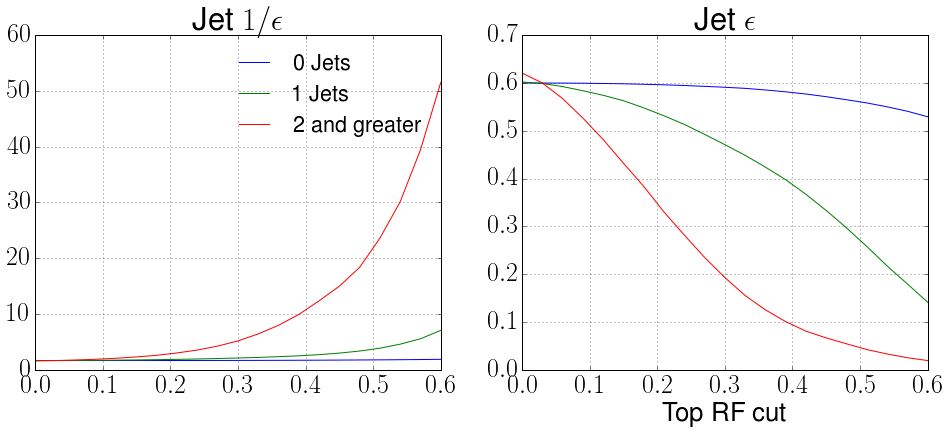

In [16]:
#Scale factors
fig , (ax1, ax2) = plt.subplots(1 ,2, figsize=(8*2,6))

ax1.plot( cuts, results[:,2,0], label="0 Jets" )
ax1.plot( cuts, results[:,2,1], label="1 Jets" )
ax1.plot( cuts, results[:,2,2], label="2 and greater" )
ax1.set_title("Jet $1/\epsilon$")
ax1.legend(frameon= False, fontsize="small", loc=1)
ax1.grid(True)

ax2.set_title("Jet $\epsilon$")
ax2.plot( cuts, results[:,2,0]**-1, label="0 Jets" )
ax2.plot( cuts, results[:,2,1]**-1, label="1 Jets" )
ax2.plot( cuts, results[:,2,2]**-1, label="2 and greater" )
plt.grid(True)

plt.xlabel("Top RF cut")


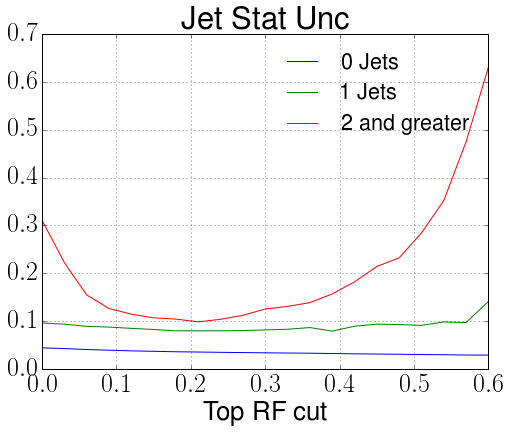

In [17]:
#Stat unc factors
plt.figure(figsize=(8,6))
plt.plot( cuts, results[:,0,0] / results[:,1,0], label="0 Jets" )
plt.plot( cuts, results[:,0,1] / results[:,1,1], label="1 Jets" )
a = plt.plot( cuts, results[:,0,2] / results[:,1,2], label="2 and greater" )

plt.grid(True)
plt.legend(frameon= False, fontsize="small")
plt.title("Jet Stat Unc")
plt.xlabel("Top RF cut")

## Norm

In [10]:
def calc_normie(df, fdy, ftt):
    total, bkg = measure_jet_multi(table_jet_multi(df, scales=scales, fdy=fdy, ftt=ftt))
    print total, bkg, fdy, ftt
    fake_data = construct_fake_data(total)

    
    tot_total, tot_bkg = measure_jet_multi(table_jet_multi(df, scales=scales, fdy=-1, ftt=-1))
    
    sf = produce_jsf(df_ww, fdy, ftt)
    print tot_total, tot_bkg, sf
    print fake_data
    temp_results = sf * (fake_data - bkg)/(sf*fake_data - sf*bkg).sum()
    
    up   = []
    down = []
    for process in scales.keys():
        #print process
        if process == "Data":
            continue
        if "WW" in process:
            continue
        if process not in df.process_decay.unique():
            continue
        def construct_fake_measurement(df, scales, fdy, ftt, sign):
            alt_scales = copy.copy(scales)
            alt_scales[process] = scales[process] * (1. + sign*unc_mc_process[process])
            a = table_jet_multi(df, fdy=fdy, ftt=ftt, scales=alt_scales)
            temp_, bkg = measure_jet_multi(a)
            fake_measurement = []
            for i in range(3):
                fake_measurement.append( sf[i] * float(fake_data[i] - bkg[i]) / ((sf*fake_data).sum() - (sf*bkg).sum())  )
            #print sign, bkg, (1. + sign*unc_mc_process[process]), scales[process], alt_scales[process]
            return fake_measurement
        
        fake_measurement = construct_fake_measurement(df, scales, fdy, ftt, 1)
        up.append(np.array(fake_measurement))

        fake_measurement = construct_fake_measurement(df, scales, fdy, ftt, -1)
        down.append(np.array(fake_measurement))
    up = np.array(up)
    down = np.array(down)
    
    np.set_printoptions(suppress=True)
    norm_unc =  ((np.abs( up - down ) / 2.)**2.).sum(0)**.5
    

    
    print "========= " + str(fdy) + " " + str(ftt) +"  ========="
    print "norm unc", norm_unc,\
    "\nnorm unc (%)", norm_unc / temp_results * 100.
    return norm_unc, temp_results, sf

In [11]:
#%%capture
results = []
cuts = []
for i in range(0,6):
    ftt = 0.6 *  i / 20.0
    cuts.append(ftt)
    results.append(calc_normie(df, 0.9, ftt))
    
cuts = np.array(cuts)
results = np.array(results)

[ 21382.  25932.  45945.] [  9122.  20050.  43152.] 0.9 0.0
[ 1328013.   398486.   228052.] [ 1308266.   388955.   223419.] [ 1.66746998  1.66131644  1.61105854]
[ 21402.  25979.  45899.]
========= 0.9 0.0  =========
norm unc [ 0.06862007  0.00343742  0.07153975] 
norm unc (%) [ 11.64595844   1.2127739   56.17692165]
[ 21382.  24968.  31843.] [  9122.  19094.  29033.] 0.9 0.03
[ 1328013.   398486.   228052.] [ 1308266.   388955.   223419.] [ 1.66762635  1.67008333  1.66687967]
[ 21402.  25014.  31804.]
========= 0.9 0.03  =========
norm unc [ 0.04955552  0.00419423  0.04571181] 
norm unc (%) [  8.46579365   1.48410621  34.62265893]
[ 21381.  23479.  24091.] [  9122.  17648.  21294.] 0.9 0.06
[ 1328013.   398486.   228052.] [ 1308266.   388955.   223419.] [ 1.66792994  1.68816083  1.76249068]
[ 21401.  23524.  24057.]
========= 0.9 0.06  =========
norm unc [ 0.03889619  0.00595931  0.03314327] 
norm unc (%) [  6.69839231   2.11887277  24.0044582 ]
[ 21372.  22318.  18876.] [  9113.  165

KeyError: MemoryError()

In [ ]:
results

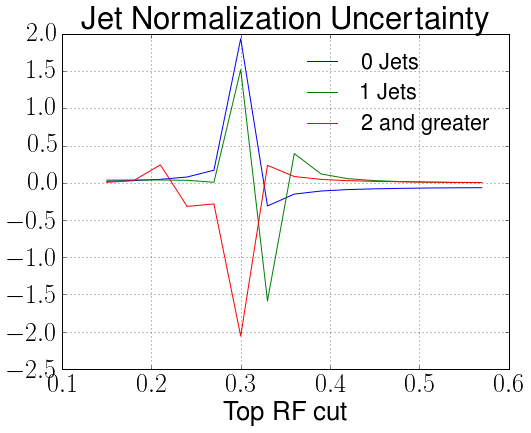

In [22]:
#Norm unc factors
plt.figure(figsize=(8,6))
plt.plot( cuts, results[:,0,0] / results[:,1,0], label="0 Jets" )
plt.plot( cuts, results[:,0,1] / results[:,1,1], label="1 Jets" )
a = plt.plot( cuts, results[:,0,2] / results[:,1,2], label="2 and greater" )

#norm unc [ 0.00648795  0.00476016  0.00209564] 
#norm unc (%) [ 0.98152573  1.81556337  2.72843057]

plt.grid(True)
plt.legend(frameon= False, fontsize="small")
plt.title("Jet Normalization Uncertainty")
plt.xlabel("Top RF cut")

In [26]:
cuts

array([ 0.15,  0.18,  0.21,  0.24,  0.27,  0.3 ,  0.33,  0.36,  0.39,  0.42])

In [29]:
results[2]

array([[ 0.00218148,  0.00092274,  0.00126663],
       [ 0.29844893,  0.42700498,  0.27454608],
       [ 1.67826634,  1.88244418,  3.02724653]])

In [45]:
a, b, c = calc_tot_stat_unc(df, 0.9, 0.2, scales=scales)

[ 24744.  21911.   8556.] [ 11982.  16789.   7257.] 0.9 0.2
[ 1420329.   425550.   244323.] [ 1404731.   418628.   243046.] [ 1.67712852  1.86145236  2.87380154]


In [47]:
a/b

array([ 0.03592418,  0.08546552,  0.19737119])

In [38]:
table_jet_multi(df, scales=scales, fdy=0.9, ftt=0.2)

[    Diff Flavor          Process  Same Flavor
 0         11622               WW         1952
 1           977  GluGluWWTo2L2Nu          287
 2         12599        Total: WW         2240
 3          1955               DY          536
 4          3491              Top          933
 5           274               WZ           77
 6             3               ZZ           50
 7           411            WG(*)           22
 8           142            Higgs           29
 9          3678               WJ          381
 10        20670            Total         4074
 11        20449             DATA         4122,
     Diff Flavor          Process  Same Flavor
 0          5276               WW          904
 1           609  GluGluWWTo2L2Nu          141
 2          5885        Total: WW         1044
 3          1094               DY         1066
 4          8388              Top         1813
 5           393               WZ           68
 6             2               ZZ           20
 7          